<a href="https://colab.research.google.com/github/pySTEPS/ERAD-nowcasting-course-2022/blob/hands-on-users/hands-on-session-users/notebooks/block_xx_advection_interpolated_accum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Precipitation accumulation with advection interpolation

In this notebook we show how to apply advection-based temporal interpolation to improve the accuracy of estimated precipitation accumulations.

Run [helper_input_data](https://github.com/pySTEPS/ERAD-nowcasting-course-2022/blob/hands-on-users/hands-on-session-users/notebooks/helper_input_data.ipynb) first to setup pysteps and download the example data.

In [1]:
from google.colab import drive
import os
# mount the Google Drive folder
# don't attempt to remount if the drive is already mounted
if not os.path.exists("/content/mnt/MyDrive"):
  drive.mount("mnt")
%cd '/content/mnt/MyDrive/Colab Notebooks'
# run the data notebook to load the input dataset
%run helper_input_data.ipynb

Mounted at mnt
/content/mnt/MyDrive/Colab Notebooks
/content/mnt/MyDrive/Colab Notebooks
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 25.9 MB/s 
Found existing installation: Shapely 1.8.2
Uninstalling Shapely-1.8.2:
  Successfully uninstalled Shapely-1.8.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 198 kB 29.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shapely: filename=Shapely-1.8.2-cp37-cp37m-linux_x86_64.whl size=668920 sha256=5140f4f64cfc49121ed618b600bb604194ce307213512258f0a2ccf8c06a9582
  Stored in directory: /root/.cache/pip/wheels/2f/9e/07/e9e90942b4e31275785d2f7e455607bfe876e53906307f80cd
Successfully built shapely
Looking in indexes: https://pypi.org/simple, https://us-pytho

Now we are ready to compute hourly precipitation accumulations.

In [74]:
import numpy as np
from pysteps.utils import transformation

from pysteps.utils.dimension import clip_domain

# Use the original FMI dataset at the 1 km resolution
precip, metadata, timestep = load_dataset('fmi')

# Pick one-hour time series between 14:45 and 15:45 UTC on 28th September 2016
precip_hour = precip[:13]
metadata_hour = metadata.copy()
metadata_hour["timestamps"] = metadata_hour["timestamps"][:13]

# Clip the domain to contain the southern Finland
precip_clipped, metadata_clipped = clip_domain(
    precip_hour,
    metadata,
    extent=(100000, 600000, 120000, 650000)
)

# First compute accumulated precipitation directly from the observations without
# temporal interpolation. This is done by assuming that each instantaneous
# precipitation rate represent the mean value during a 5-minute interval.
precip_accum_nointerp = np.mean(np.stack(np.array(precip_clipped)), axis=0)

# Then proceed with computation of accumulated precipitation from temporally
# interpolated fields
from scipy.ndimage import map_coordinates
from pysteps import motion

# Log-transform to dB units before applying the optical flow
precip_dbr, metadata_dbr = transformation.dB_transform(
    precip_clipped,
    metadata_clipped,
    threshold=0.1,
    zerovalue=-15.0
)

# Estimate the motion field by using the Lucas-Kanade method with 6 time steps
# (30 minutes)
oflow = motion.get_method("LK")
motion_field = oflow(precip_dbr[-6:], verbose=False)

# Our observation time step is 5 minutes
obs_timestep = 5
# The chosen time step between the interpolated fields is 0.25 minutes (15 seconds)
interp_timestep = 0.25

# Here we use scipy.ndimage.map_coordinates. This requires the x- and y-coordinates
# of our grid.
x, y = np.meshgrid(
    np.arange(precip_clipped[0].shape[1], dtype=float),
    np.arange(precip_clipped[0].shape[0], dtype=float)
)

# Define a function for advection-based temporal interpolation. For two given
# precipitation fields, it returns the interpolated time frames between them.
# The endpoints of the interval are not included.
def interpolate(precip1, precip2):
    out = []

    for t in np.arange(interp_timestep, obs_timestep, interp_timestep):
        # Extrapolate the first precipitation field forward by time t / obs_timestep
        coords1 = (y - t / obs_timestep * motion_field[1],
                   x - t / obs_timestep * motion_field[0])
        # Here we use interpolation order 1. Alternatively, we could use
        # extrapolation.semilagrangian.extrapolate here to take advantage of
        # the more advanced functionality.
        precip1_warped = map_coordinates(precip1, coords1, order=0)

        # Extrapolate the second precipitation field forward by time
        # (obs_timestep - t) / obs_timestep
        coords2 = (y + (obs_timestep - t) / obs_timestep * motion_field[1],
                   x + (obs_timestep - t) / obs_timestep * motion_field[0])
        precip2_warped = map_coordinates(precip2, coords2, order=0)

        # Compute interpolated value from precip1 and precip2 that are
        # extrapolated to the same time
        out.append((obs_timestep - t) / obs_timestep * precip1_warped +
                   t / obs_timestep * precip2_warped)

    return out

# Finally compute accumulated precipitation from the interpolated sequence.
# First include the observation time steps that are not interpolated.
precip_accum_interp = np.sum(np.stack(np.array(precip_clipped)), axis=0)
n = len(precip_clipped)
for i in range(len(precip_clipped))[:-1]:
    precip_interp = interpolate(precip_clipped[i], precip_clipped[i+1])
    precip_accum_interp += np.sum(np.stack(np.array(precip_interp)), axis=0)
    n += len(precip_interp)
precip_accum_interp /= n

Let's then plot the hourly accumulations computed without and with temporal interpolation (time steps 5 minutes and 15 seconds, respectively). This comparison clearly shows that the latter produces a smooth field, whereas the former has the jagged appearance. This is because of the limited time resolution, which makes impossible to capture the motion of precipitation between the time steps.

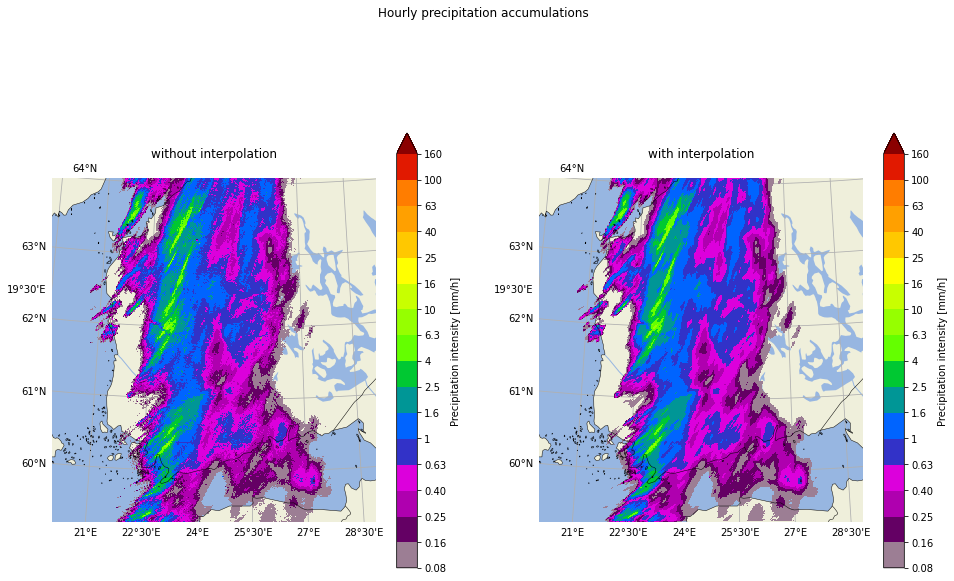

In [75]:
from matplotlib import pyplot as plt
from pysteps.visualization import plot_precip_field

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(16, 10))

plt.subplot(121)
plot_precip_field(
    precip_accum_nointerp,
    geodata=metadata_clipped,
    map_kwargs={"drawlonlatlines": True}
)
plt.title("without interpolation")

plt.subplot(122)

plot_precip_field(
    precip_accum_interp,
    geodata=metadata_clipped,
    map_kwargs={"drawlonlatlines": True}
)
plt.title("with interpolation")

plt.suptitle("Hourly precipitation accumulations")
plt.show()